In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple

import corner


In [2]:
from starccato_flow.data.toy_data import ToyData
from starccato_flow.data.ccsn_snr_data import CCSNSNRData
from starccato_flow.training.trainer import Trainer

from starccato_flow.plotting.plotting import plot_reconstruction_distribution, plot_candidate_signal

/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_snr_data.py:67: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (


MPS device found


/Users/tarineccleston/Desktop/starccato/starccato-flow/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/tarineccleston/Desktop/starccato/starccato-flow/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from starccato_flow.utils.defaults import DEVICE

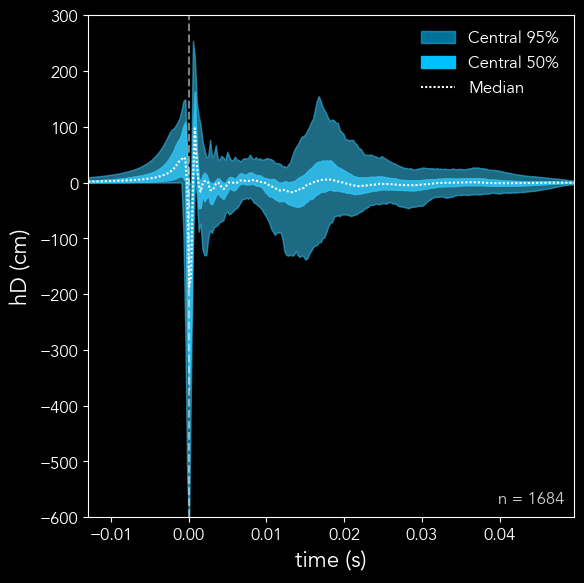

In [4]:
ccsn_dataset = CCSNSNRData(noise=True, curriculum=False)
ccsn_dataset.plot_signal_distribution(background="black", font_family="sans-serif", font_name="Avenir", fname="plots/ccsn_signal_distribution.svg")

In [5]:
toy=False


=== Data Split (on base signals) ===
Total base signals: 1684
Training base signals: 1516
Validation base signals: 168
First 5 training indices: [ 360  336   81  684 1374]
First 5 validation indices: [722 519 222  32 111]
✓ Verification PASSED: No overlap between train and validation sets
  Train signals: 1516 unique indices
  Val signals: 168 unique indices
  Total coverage: 1684 / 1684

Verifying data alignment:
Number of signals: 1516
Number of parameter sets: 1516
Parameter columns: ['beta1_IC_b', 'A(km)', 'Ye_c_b', 'omega_0(rad|s)']
First few parameter values:
      beta1_IC_b  A(km)   Ye_c_b  omega_0(rad|s)
369     0.144352    467  0.26472             8.5
345     0.121586    300  0.26472            10.0
84      0.172129    300  0.27792            12.5
708     0.001442    300  0.28282             1.0
1447    0.047885    634  0.28170             4.0

Verifying data alignment:
Number of signals: 168
Number of parameter sets: 168
Parameter columns: ['beta1_IC_b', 'A(km)', 'Ye_c_b', 

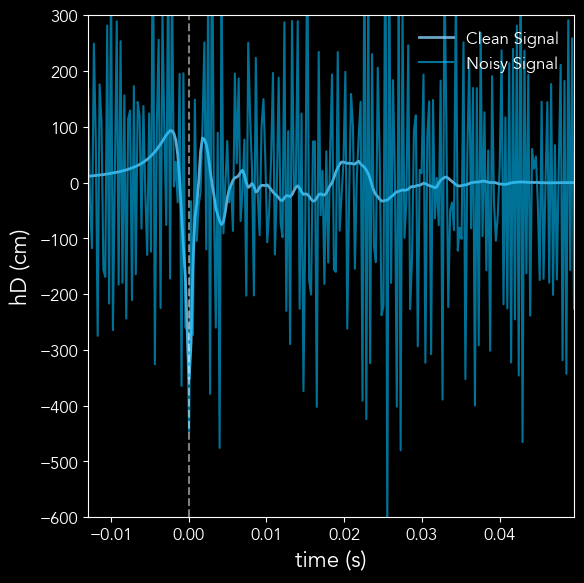

Epochs:   1%|          | 2/256 [00:05<11:28,  2.71s/it]

In [ ]:
trainer = Trainer(
    toy=False, 
    start_snr=200,
    end_snr=10,
    noise=True, 
    validation_split=0.1,
    curriculum=True,
    noise_realizations=1
)

trainer.val_loader.dataset.update_snr(10)
index = 200  # Changed from 200 to 50 (validation has ~168 samples)
plot_candidate_signal(
    signal=trainer.val_loader.dataset.__getitem__(index)[0],
    noisy_signal=trainer.val_loader.dataset.__getitem__(index)[1],
    max_value=trainer.val_loader.dataset.max_strain,
    background="black",
    fname="plots/ccsn_candidate_signal.svg"
)
trainer.train()

In [ ]:
trainer.display_results()

In [ ]:
# index = 9

# val_idx = trainer.validation_sampler.indices[index]
# signal, noisy_signal, params = trainer.val_loader.dataset.__getitem__(val_idx)

# trainer.plot_reconstruction_distribution(
#     num_samples=1000,
#     background="white",
#     font_family="sans-serif",
#     font_name="Avenir"
# )

In [ ]:
# Check 2: Does the flow produce different posteriors for different latents?
print("\n" + "=" * 60)
print("DIAGNOSTIC: Checking Flow Posterior Predictions")
print("=" * 60)

num_samples = 1000

for i, idx in enumerate(test_indices[:3]):  # Test 3 signals
    signal, noisy_signal, params = trainer.training_dataset[idx]
    
    # Encode to latent (data is already tensor from dataset)
    with torch.no_grad():
        if isinstance(noisy_signal, np.ndarray):
            noisy_signal_tensor = torch.from_numpy(noisy_signal).unsqueeze(0).to(DEVICE)
        else:
            noisy_signal_tensor = noisy_signal.unsqueeze(0).to(DEVICE)
            
        _, mean, _ = trainer.vae(noisy_signal_tensor)
        z_latent = mean.view(1, -1)
        
        # Sample from flow conditioned on this latent
        samples = trainer.flow.sample(num_samples, context=z_latent).cpu().numpy()
        samples = np.exp(samples) - 1e-8  # Reverse log transform
    
    # Convert params to numpy if needed
    if isinstance(params, torch.Tensor):
        params = params.cpu().numpy()
    
    print(f"\nSignal {idx}:")
    print(f"  True params: {params.flatten()}")
    print(f"  Predicted mean: {samples.mean(axis=0)}")
    print(f"  Predicted std:  {samples.std(axis=0)}")

print("\n" + "=" * 60)
print("If predicted means are all similar, flow is NOT conditioning properly!")
print("=" * 60)